In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import mean, stddev

In [0]:
# Verificar que los datos se han guardado en la tabla Delta
df_delta = spark.read.format("delta").table("default.cleaned_retail")
df_delta.show(5)  # Ver las primeras 5 filas

+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+----+-----+
|Transaction_ID|      Date|Customer_ID|Gender|Age|Product_Category|Quantity|Price_per_Unit|Total_Amount|year|month|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+----+-----+
|           974|2023-05-03|    CUST974|  Male| 47|          Beauty|       1|            30|          30|2023|    5|
|           155|2023-05-17|    CUST155|  Male| 31|     Electronics|       4|           500|        2000|2023|    5|
|           758|2023-05-12|    CUST758|  Male| 64|        Clothing|       4|            25|         100|2023|    5|
|           414|2023-05-09|    CUST414|  Male| 48|          Beauty|       4|            25|         100|2023|    5|
|           946|2023-05-08|    CUST946|  Male| 62|     Electronics|       4|           500|        2000|2023|    5|
+--------------+----------+-----------+------+---+----------------+-----

In [0]:
from pyspark.sql.functions import col

# Convertir columnas a tipos apropiados
df_delta = df_delta.withColumn("Age", col("Age").cast("integer")) \
                   .withColumn("Quantity", col("Quantity").cast("integer")) \
                   .withColumn("Price_per_Unit", col("Price_per_Unit").cast("double")) \
                   .withColumn("Total_Amount", col("Total_Amount").cast("double"))
df_delta.printSchema()


root
 |-- Transaction_ID: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price_per_Unit: double (nullable = true)
 |-- Total_Amount: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [0]:
df_delta.show()

+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+----+-----+
|Transaction_ID|      Date|Customer_ID|Gender|Age|Product_Category|Quantity|Price_per_Unit|Total_Amount|year|month|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+----+-----+
|           974|2023-05-03|    CUST974|  Male| 47|          Beauty|       1|          30.0|        30.0|2023|    5|
|           155|2023-05-17|    CUST155|  Male| 31|     Electronics|       4|         500.0|      2000.0|2023|    5|
|           758|2023-05-12|    CUST758|  Male| 64|        Clothing|       4|          25.0|       100.0|2023|    5|
|           414|2023-05-09|    CUST414|  Male| 48|          Beauty|       4|          25.0|       100.0|2023|    5|
|           946|2023-05-08|    CUST946|  Male| 62|     Electronics|       4|         500.0|      2000.0|2023|    5|
|           729|2023-05-23|    CUST729|  Male| 29|        Clothing|     

In [0]:
# Realizar análisis descriptivo de los datos
df_delta.describe().show()

+-------+-----------------+-----------+------+------------------+----------------+-----------------+----------------+----------------+--------------------+-----------------+
|summary|   Transaction_ID|Customer_ID|Gender|               Age|Product_Category|         Quantity|  Price_per_Unit|    Total_Amount|                year|            month|
+-------+-----------------+-----------+------+------------------+----------------+-----------------+----------------+----------------+--------------------+-----------------+
|  count|             2000|       2000|  2000|              2000|            2000|             2000|            2000|            2000|                2000|             2000|
|   mean|            500.5|       NULL|  NULL|            41.392|            NULL|            2.514|          179.89|           456.0|            2023.002|            6.549|
| stddev|288.7471860793354|       NULL|  NULL|13.678007162593902|            NULL|1.132450980224445|189.633906275235|559.857544590

In [0]:
#ANALISIS DE DISNTRIBUCION 

# Distribución por género
df_delta.groupBy("Gender").count().show()

# Distribución por categoría de producto
df_delta.groupBy("Product_Category").count().show()


+------+-----+
|Gender|count|
+------+-----+
|Female| 1020|
|  Male|  980|
+------+-----+

+----------------+-----+
|Product_Category|count|
+----------------+-----+
|     Electronics|  684|
|        Clothing|  702|
|          Beauty|  614|
+----------------+-----+



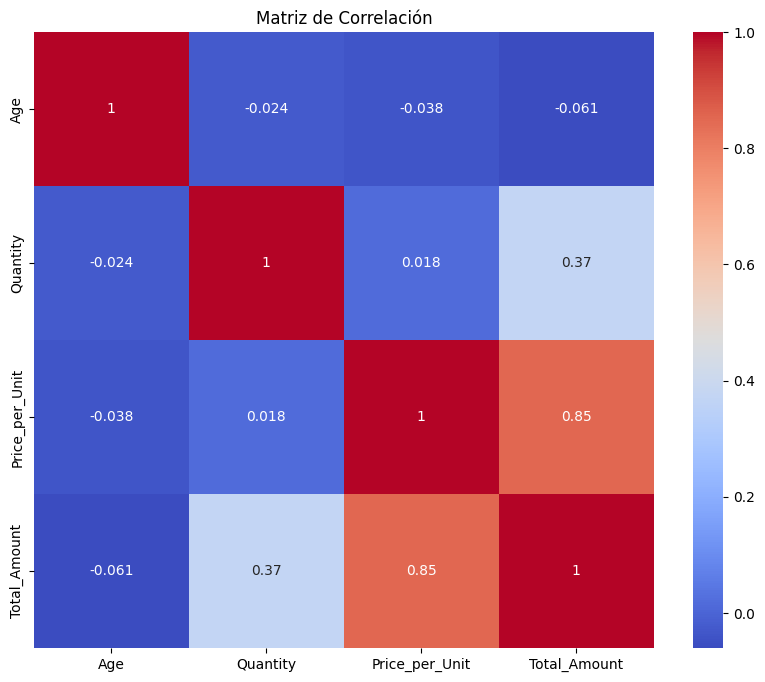

In [0]:
# CORRELACION DE VARIABLES


# Convertir a pandas para graficar
pandas_df = df_delta.select("Age", "Quantity", "Price_per_Unit", "Total_Amount").toPandas()

# Calcular la matriz de correlación
corr = pandas_df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()


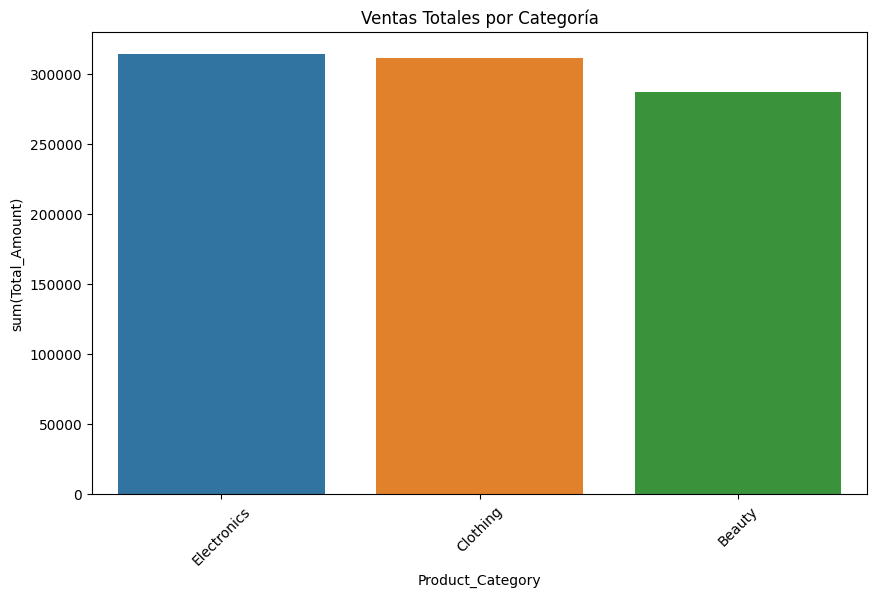

In [0]:
# VENTAS POR CATERGORIA 

ventas_por_categoria = df_delta.groupBy("Product_Category").sum("Total_Amount").toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=ventas_por_categoria, x="Product_Category", y="sum(Total_Amount)")
plt.title("Ventas Totales por Categoría")
plt.xticks(rotation=45)
plt.show()


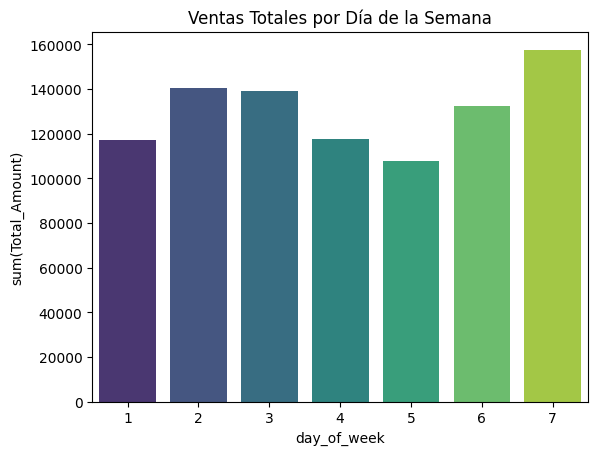

In [0]:
#VENTAS POR DIA AGRUPACION 

from pyspark.sql.functions import dayofweek

# Extract day of the week from the Date column
df_delta = df_delta.withColumn("day_of_week", dayofweek("Date"))

# Group by day_of_week and sum Total_Amount
ventas_por_dia = df_delta.groupBy("day_of_week").sum("Total_Amount").toPandas()

# Plotting
sns.barplot(
    data=ventas_por_dia,
    x="day_of_week",
    y="sum(Total_Amount)",
    palette="viridis"
)
plt.title("Ventas Totales por Día de la Semana")
plt.show()


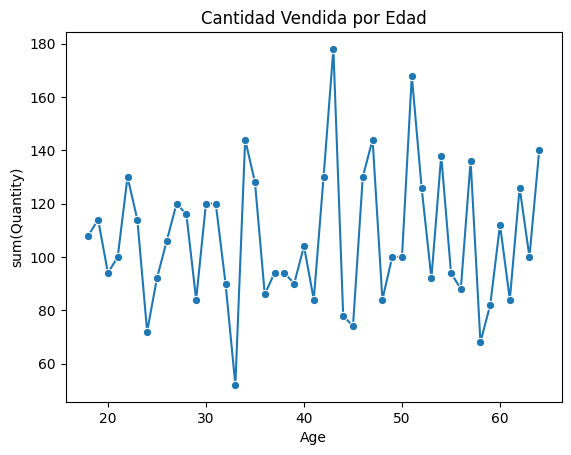

In [0]:
#VENTAS POR RANGO DE EDAD

edad_cantidad = df_delta.groupBy("Age").sum("Quantity").toPandas()
sns.lineplot(data=edad_cantidad, x="Age", y="sum(Quantity)", marker="o")
plt.title("Cantidad Vendida por Edad")
plt.show()


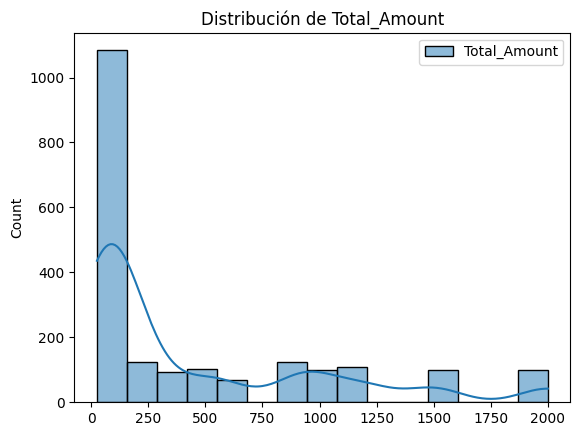

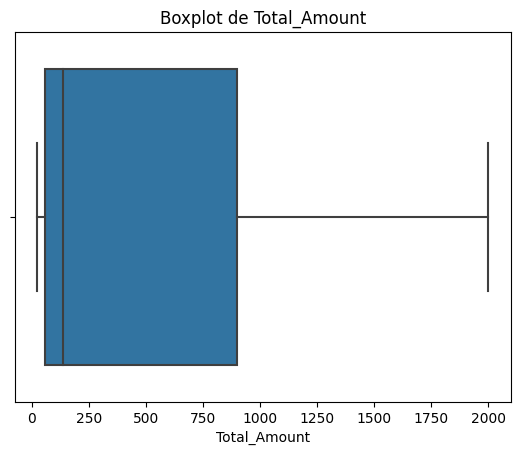

In [0]:
#OUTLIERS

# Histograma de ventas totales
sns.histplot(df_delta.select("Total_Amount").toPandas(), kde=True)
plt.title('Distribución de Total_Amount')
plt.show()

# Boxplot para detectar outliers en Total_Amount
sns.boxplot(x=df_delta.select("Total_Amount").toPandas()["Total_Amount"])
plt.title('Boxplot de Total_Amount')
plt.show()

